In [23]:
from Statistics_and_Seq2Seq.all_functions import *
from aeon.visualisation import plot_series
from statsmodels.tsa.statespace.varmax import VARMAX
import os
def read_series(file_path):
    df = pd.read_csv(file_path, header=0, parse_dates=['timestamp'], sep=";", date_parser=custom_parser)
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
    df = df.set_index('timestamp', inplace=False)
    df.index = df.index.to_period('M')
    series = df['m3']
    return series

def znorm_mean_std(x, mean, std):
  x_znorm = (x - mean) / std
  return x_znorm

def varmax_recursive(data, horizon, order=(1,1)):
  data_predict = data.copy()
  for _ in range(horizon):    

    model = VARMAX(data_predict, freq = 'M', order=order)
    fitted_model = model.fit(disp=False)
    next_prediction = fitted_model.forecast(steps=1)
    data_predict = pd.concat([data_predict, next_prediction])
  return data_predict, data_predict.tail(12)

   

In [24]:
data_dict = {}
test_dict = {}
train_real = {}
dirs = [
    # './datasets/venda/mensal/uf/gasolinac/',
    # './datasets/venda/mensal/uf/etanolhidratado/',
    # './datasets/venda/mensal/uf/gasolinadeaviacao/',
    # './datasets/venda/mensal/uf/glp/',
    './datasets/venda/mensal/uf/oleocombustivel/',
    # './datasets/venda/mensal/uf/oleodiesel/',
    # './datasets/venda/mensal/uf/querosenedeaviacao/',
    # './datasets/venda/mensal/uf/queroseneiluminante/',
]
path_derivado = f'./datasets/venda/mensal/uf/oleocombustivel'

cont = 0
for directory in dirs:
    for file in os.listdir(directory): 
        if file.endswith('.csv'):
            full_path = os.path.join(directory, file)
            derivado = directory.split('/')[-2]
            uf = file.split("_")[1].upper()
            series = read_series(full_path)
            train, test = train_test_stats(series, 12)
            train_tf = transform_train(train, horizon=12, format="normal")
            train_norm, mean, std = rolling_window_series(train_tf, 12)
            test_norm = znorm_mean_std(test, mean, std)
            data_dict[uf] = train_norm
            test_dict[uf] = test_norm
            train_real[uf] = train
            cont+=1
            # if cont == 6:
            #     break
train_transformed = pd.DataFrame(data_dict)
tests = pd.DataFrame(test_dict)
train_normal = pd.DataFrame(train_real)
# print(combined_data)

In [25]:
def forecast_varmax(train, initial_order=(13, 13)):
    flag = True
    order = initial_order
    isP = True
    while flag:
        try:
            model = VARMAX(train, freq='M', order=order)
            fitted_model = model.fit(disp=False)
            preds = fitted_model.forecast(steps=12)
            return preds, order
        except Exception as e:
            error_message = str(e)
            print_log(f"Error: {error_message}")
            print_log(f"Error: Not valid {str(order)} decrementing...")
            p, q = order
            if isP and p > 0:
                p -= 1
            elif not isP and q > 0:
                q -= 1
            else:
                flag = False
            isP = not isP
            order = (p, q)
        

In [26]:
horizon = 12
def euclidean_dist(serie1, serie2):
    dist = np.linalg.norm(serie1 - serie2)
    return dist

def build_state_matrix(states):
    n = len(states)
    matrix = pd.DataFrame(np.zeros((n, n)), index=states, columns=states)
    return matrix

def make_matrix(path_derivado):
    csv_files = [file for file in os.listdir(path_derivado) if file.endswith('.csv')]
    states = []
    for csv_file in csv_files:  
        start = csv_file.find('mensal_') + len('mensal_')
        end = csv_file.find('_', start)
        state = csv_file[start:end].upper()
        
        states.append(state)
            
    return build_state_matrix(states)

def euclidean_series(matrix, path_derivado, transform):
    derivado = path_derivado.split("/")[-1]
    for row in matrix.itertuples():
        row_header = row.Index
        for col_header in matrix.columns:
            if row_header != col_header:
                series_row = read_series(f"{path_derivado}/mensal_{row_header.lower()}_{derivado}.csv")
                series_col = read_series(f"{path_derivado}/mensal_{col_header.lower()}_{derivado}.csv")
                train_row, _ = train_test_stats(series_row, horizon)
                train_col, _ = train_test_stats(series_col, horizon)
                if transform != "serie-desnormalizada":
                    train_row = transform_train(train_row, format=transform)
                    train_col = transform_train(train_col, format=transform)
                    
                matrix.at[row_header, col_header] = euclidean_dist(train_row, train_col)

    return matrix
def similar_states(matrix, x, estado):
    filtered_values = matrix[estado].copy()
    filtered_values = filtered_values.drop(estado)
    
    # Obtém os X menores valores
    smallest_values = filtered_values.nsmallest(x)
    
    return smallest_values


In [27]:
matrix = make_matrix(path_derivado)
matrix_euclid = euclidean_series(matrix, path_derivado, "normal")

euclidean_states = similar_states(matrix_euclid, 3, "MT").keys().tolist()
euclidean_states.append("MT")


In [28]:
euclidean_states

['PB', 'GO', 'RO', 'MT']

In [29]:
preds2 = forecast_varmax(train_transformed[euclidean_states])
preds2
# model = VARMAX(train, freq='M', order=(14,14))
# fitted_model = model.fit(disp=False)
# preds = fitted_model.forecast(steps=12)

(               PB        GO        RO        MT
 2023-03 -0.435569 -0.695143 -0.606196  0.123700
 2023-04 -0.268247 -0.817543 -0.450587  0.469603
 2023-05 -0.116746  0.026536 -0.041880  0.161828
 2023-06  0.136531  0.034997  0.375301  1.030811
 2023-07  0.015384 -0.063176  0.025037 -0.056960
 2023-08  0.128342  0.185395  0.526087 -0.182147
 2023-09  0.405629 -0.056973 -0.120705  0.316213
 2023-10  0.010224  0.205468  1.015334 -0.922956
 2023-11  0.226950 -0.257284  0.482792 -0.303511
 2023-12  0.152663 -0.169185  0.199791 -1.042972
 2024-01  0.053668 -0.503280  0.021098 -0.235994
 2024-02  0.285987  0.080206  0.028214 -0.281592,
 (13, 13))

In [30]:
plot_series(preds2['AP'])

TypeError: tuple indices must be integers or slices, not str

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='ES'>)

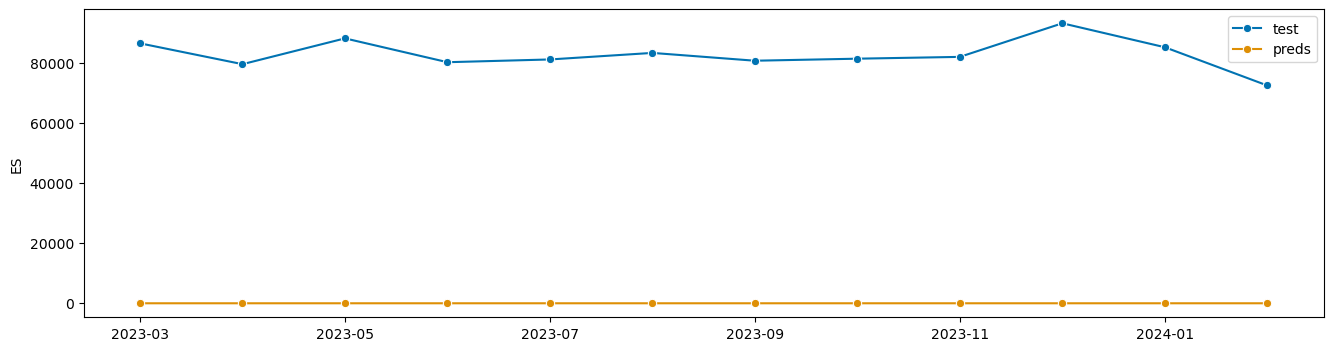

In [ ]:
plot_series(tests['ES'], preds2['ES'], labels=["test", "preds"])

In [ ]:
horizon = 12

In [ ]:
def process_csv_files(directory):
    # Verifica se o diretório existe
    if not os.path.isdir(directory):
        print(f"O diretório {directory} não existe.")
        return

    # Percorre todos os arquivos no diretório
    for filename in os.listdir(directory):
        # Verifica se o arquivo é um .csv
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            
            # Lê o arquivo CSV
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()

                # Verifica se há pelo menos uma linha no arquivo
                if lines:
                    # Remove a ocorrência de "SAVED MODEL;" da primeira linha
                    lines[0] = lines[0].replace("SAVED MODEL;", "")

                    # Escreve as linhas de volta no arquivo
                    with open(file_path, 'w', encoding='utf-8') as file:
                        file.writelines(lines)

                print(f"Arquivo processado: {filename}")

            except Exception as e:
                print(f"Erro ao processar o arquivo {filename}: {e}")

# Exemplo de uso
diretorio = './Statistics_and_Seq2Seq/results/sarima/rolling/queroseneiluminante'
process_csv_files(diretorio)

Arquivo processado: transform_GO.csv
Arquivo processado: transform_PA.csv
Arquivo processado: transform_SP.csv
Arquivo processado: transform_PI.csv
Arquivo processado: transform_PR.csv
Arquivo processado: transform_MT.csv
Arquivo processado: transform_ES.csv
Arquivo processado: transform_RS.csv
Arquivo processado: transform_RR.csv
Arquivo processado: transform_SC.csv
Arquivo processado: transform_PE.csv
Arquivo processado: transform_MA.csv
Arquivo processado: transform_SE.csv
Arquivo processado: transform_PB.csv
Arquivo processado: transform_DF.csv
Arquivo processado: transform_MS.csv
Arquivo processado: transform_MG.csv
Arquivo processado: transform_TO.csv
Arquivo processado: transform_RJ.csv
Arquivo processado: transform_AM.csv
Arquivo processado: transform_AP.csv
Arquivo processado: transform_CE.csv
Arquivo processado: transform_AL.csv
Arquivo processado: transform_RN.csv
Arquivo processado: transform_BA.csv
Arquivo processado: transform_RO.csv
Arquivo processado: transform_AC.csv
